In [1]:
# Import necessary libraries
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

In [2]:
# step 01 : pre processing the data 

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
import pandas as pd
import ssl
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


statlog_german_credit_data = fetch_ucirepo(id=8)


X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets


X = X.apply(pd.to_numeric, errors='ignore')


label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le


if 'identifier' in X.columns:
    X = X.drop(columns=['identifier'])


print(X.dtypes) 

age_gt_60                  int32
air                        int32
airBoneGap                 int32
ar_c                       int32
ar_u                       int32
                           ...  
static_normal              int32
tymp                       int32
viith_nerve_signs          int32
wave_V_delayed             int32
waveform_ItoV_prolonged    int32
Length: 69, dtype: object


C:\Users\techs\AppData\Local\Temp\ipykernel_17584\965696158.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X = X.apply(pd.to_numeric, errors='ignore')


In [3]:
# normalization and pca analysis 
X_train , X_test, y_train , y_test = train_test_split(X, y , test_size = 0.2 , random_state =42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=10) 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


print(X_train_pca.shape)
print(X_test_pca.shape)

(160, 10)
(40, 10)


In [4]:
def time_series_data(series , input_size=1, output_size=1):
    X_seq , y_seq = [] , []
    for i in range(len(series) - input_size - output_size):
        X_seq.append(series[i:i + input_size])
        y_seq.append(series[i + input_size:i + input_size + output_size])
    return np.array(X_seq), np.array(y_seq)


In [5]:
X_series = X_train_pca[:, 0]
X_seq , y_seq = time_series_data(X_series)

In [6]:
X_train_seq , X_test_seq, y_train_seq , y_test_seq = train_test_split(X_seq, y_seq , test_size = 0.2 , shuffle=False)

In [7]:
print("X_train_seq shape :", X_train_seq.shape)
print("X_train_seq shape :", X_test_seq.shape)
print("X_train_seq shape :", y_train_seq.shape)
print("X_train_seq shape :", y_test_seq.shape)

X_train_seq shape : (126, 1)
X_train_seq shape : (32, 1)
X_train_seq shape : (126, 1)
X_train_seq shape : (32, 1)


In [8]:
#reserviour 

def quantum_reservoir(data_point, qubits, theta_1, theta_2 , reservoir_depth=5, seed=42):
    np.random.seed(seed)

    reservoir_circuit = QuantumCircuit(qubits)

    for i , value in enumerate(data_point):
        reservoir_circuit.h(i)
        reservoir_circuit.rx(2 * np.pi * value, i)
        reservoir_circuit.ry(np.pi * value, i)
        reservoir_circuit.rz(3 * np.pi * value, i)


    for _ in range(reservoir_depth):
        for qubit in range(qubits):
            reservoir_circuit.ry(np.random.uniform(0, np.pi), qubit)

        for qubit in range(qubits-1):
            reservoir_circuit.cx(qubit, qubit+1)

        for qubit in range(qubits-2):
            reservoir_circuit.crx(theta_1, qubit, qubit+1)
            reservoir_circuit.crz(theta_2, qubit+1, qubit+2)

    reservoir_circuit.measure_all()

    return reservoir_circuit
        

In [9]:

from qiskit_aer import Aer , AerSimulator


def extract_features(data, qubits):
    features = []
    for data_point in data:
        reservoir_circuit = quantum_reservoir(data_point, qubits, theta_1, theta_2 , reservoir_depth)
       
        simulator = AerSimulator()
        transpiled_circuit = transpile(reservoir_circuit, simulator)
        job = simulator.run(transpiled_circuit, shots=1024)
        result = job.result()
        counts = result.get_counts()
        
        
        feature_vector = [counts.get(f"{i:0{qubits}b}", 0) / 1024 for i in range(2**qubits)]
        features.append(feature_vector)
    
    return np.array(features)

theta_1 = np.pi / 6
theta_2 = np.pi / 4
reservoir_depth = 30


In [10]:
# Extract quantum features for training and testing datasets
qubits = 15
X_train_quantum = extract_features(X_train_seq, qubits)
X_test_quantum = extract_features(X_test_seq, qubits)


In [11]:
print(X_train_quantum.shape)
print("sample feature : " , X_train_quantum[:20])
print(X_test_quantum.shape)

(126, 32768)
sample feature :  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(32, 32768)


In [12]:
from sklearn.ensemble import RandomForestRegressor
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_seq)
y_test_scaled = y_scaler.transform(y_test_seq)


regressor = RandomForestRegressor(n_estimators=100, random_state=42)  
regressor.fit(X_train_quantum, y_train_scaled.ravel())


y_pred_scaled = regressor.predict(X_test_quantum)


y_test_rescaled = y_scaler.inverse_transform(y_test_scaled)
y_pred_rescaled = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)) 

In [13]:
regressor_classical = RandomForestRegressor(n_estimators=100, random_state=42)
regressor_classical.fit(X_train_seq, y_train_scaled.ravel())


y_pred_classical_scaled = regressor_classical.predict(X_test_seq)
y_pred_classical_rescaled = y_scaler.inverse_transform(y_pred_classical_scaled.reshape(-1, 1))


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

mse_classical = mean_squared_error(y_test_seq, y_pred_classical_rescaled)
r2_classical = r2_score(y_test_seq, y_pred_classical_rescaled)

mse_quantum = mean_squared_error(y_test_seq, y_pred_rescaled)
r2_quantum = r2_score(y_test_seq, y_pred_rescaled)

print("\n🔍 Performance Comparison:")
print(f"Classical Model (PCA + RF) -> MSE: {mse_classical:.4f}, R²: {r2_classical:.4f}")
print(f"Quantum Model (QRC + RF) -> MSE: {mse_quantum:.4f}, R²: {r2_quantum:.4f}")



🔍 Performance Comparison:
Classical Model (PCA + RF) -> MSE: 0.6112, R²: -0.3064
Quantum Model (QRC + RF) -> MSE: 0.4029, R²: 0.1387



🔍 Performance Comparison:
Classical Model (PCA + RF) -> MSE: 0.6112, R²: -0.3064
Quantum Model (QRC + RF) -> MSE: 0.4029, R²: 0.1387


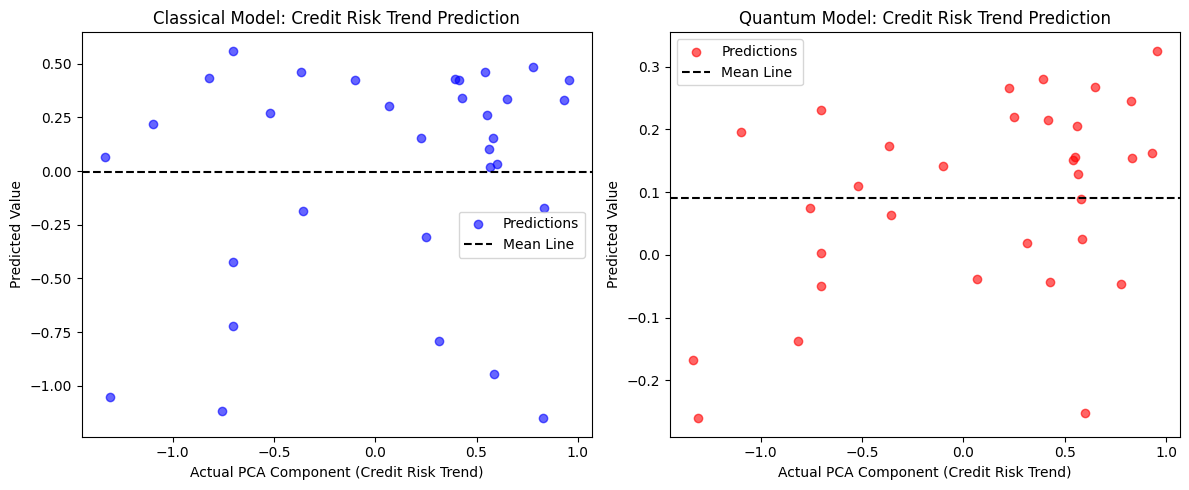

In [15]:
import matplotlib.pyplot as plt
print("\n🔍 Performance Comparison:")
print(f"Classical Model (PCA + RF) -> MSE: {mse_classical:.4f}, R²: {r2_classical:.4f}")
print(f"Quantum Model (QRC + RF) -> MSE: {mse_quantum:.4f}, R²: {r2_quantum:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_seq, y_pred_classical_rescaled, color="blue", alpha=0.6, label="Predictions")
plt.axhline(y=np.mean(y_pred_classical_rescaled), color="black", linestyle="dashed", label="Mean Line")
plt.title("Classical Model: Credit Risk Trend Prediction")
plt.xlabel("Actual PCA Component (Credit Risk Trend)")
plt.ylabel("Predicted Value")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_seq, y_pred_rescaled, color="red", alpha=0.6, label="Predictions")
plt.axhline(y=np.mean(y_pred_rescaled), color="black", linestyle="dashed", label="Mean Line")
plt.title("Quantum Model: Credit Risk Trend Prediction")
plt.xlabel("Actual PCA Component (Credit Risk Trend)")
plt.ylabel("Predicted Value")
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from sklearn.svm import SVR
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_seq, y_train_scaled.ravel())

# Predict with SVM Model
y_pred_svm_scaled = svm_model.predict(X_test_seq)
y_pred_svm_rescaled = y_scaler.inverse_transform(y_pred_svm_scaled.reshape(-1, 1))

# Evaluate SVM Model
mse_svm = mean_squared_error(y_test_seq, y_pred_svm_rescaled)
r2_svm = r2_score(y_test_seq, y_pred_svm_rescaled)

print("\n🔍 Performance Comparison:")
print(f"SVM Model (Time-Series + SVR) -> MSE: {mse_svm:.4f}, R²: {r2_svm:.4f}")


🔍 Performance Comparison:
SVM Model (Time-Series + SVR) -> MSE: 0.4871, R²: -0.0411



🔍 Performance Comparison:
SVM Model (Time-Series + SVR) -> MSE: 0.4871, R²: -0.0411
Quantum Model (QRC + RF) -> MSE: 0.4029, R²: 0.1387


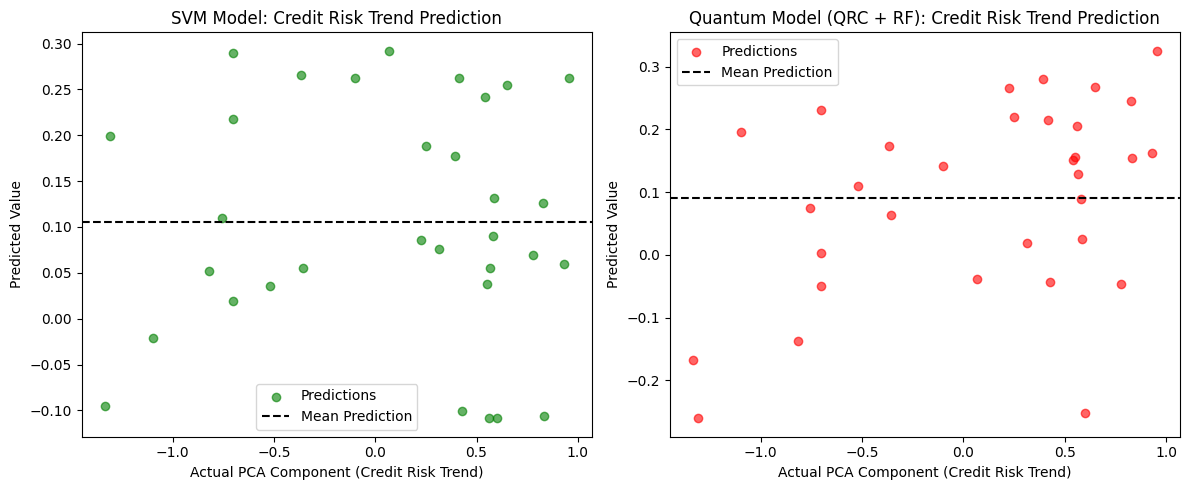

In [17]:
print("\n🔍 Performance Comparison:")
print(f"SVM Model (Time-Series + SVR) -> MSE: {mse_svm:.4f}, R²: {r2_svm:.4f}")
print(f"Quantum Model (QRC + RF) -> MSE: {mse_quantum:.4f}, R²: {r2_quantum:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_seq, y_pred_svm_rescaled, color="green", alpha=0.6,label="Predictions")
plt.axhline(y=np.mean(y_pred_svm_rescaled), color="black", linestyle="dashed",label="Mean Prediction")
plt.title("SVM Model: Credit Risk Trend Prediction")
plt.xlabel("Actual PCA Component (Credit Risk Trend)")
plt.ylabel("Predicted Value")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_seq, y_pred_rescaled, color="red", alpha=0.6, label="Predictions")
plt.axhline(y=np.mean(y_pred_rescaled), color="black", linestyle="dashed",label="Mean Prediction")
plt.title("Quantum Model (QRC + RF): Credit Risk Trend Prediction")
plt.xlabel("Actual PCA Component (Credit Risk Trend)")
plt.ylabel("Predicted Value")
plt.legend()

plt.tight_layout()
plt.show()



🔍 Performance Comparison:
SVM Model (Time-Series + SVR) -> MSE: 0.4871, R²: -0.0411
Gradient Boosting Model (Time-Series + GB) -> MSE: 0.5469, R²: -0.1690
Quantum Model (QRC + RF) -> MSE: 0.4029, R²: 0.1387


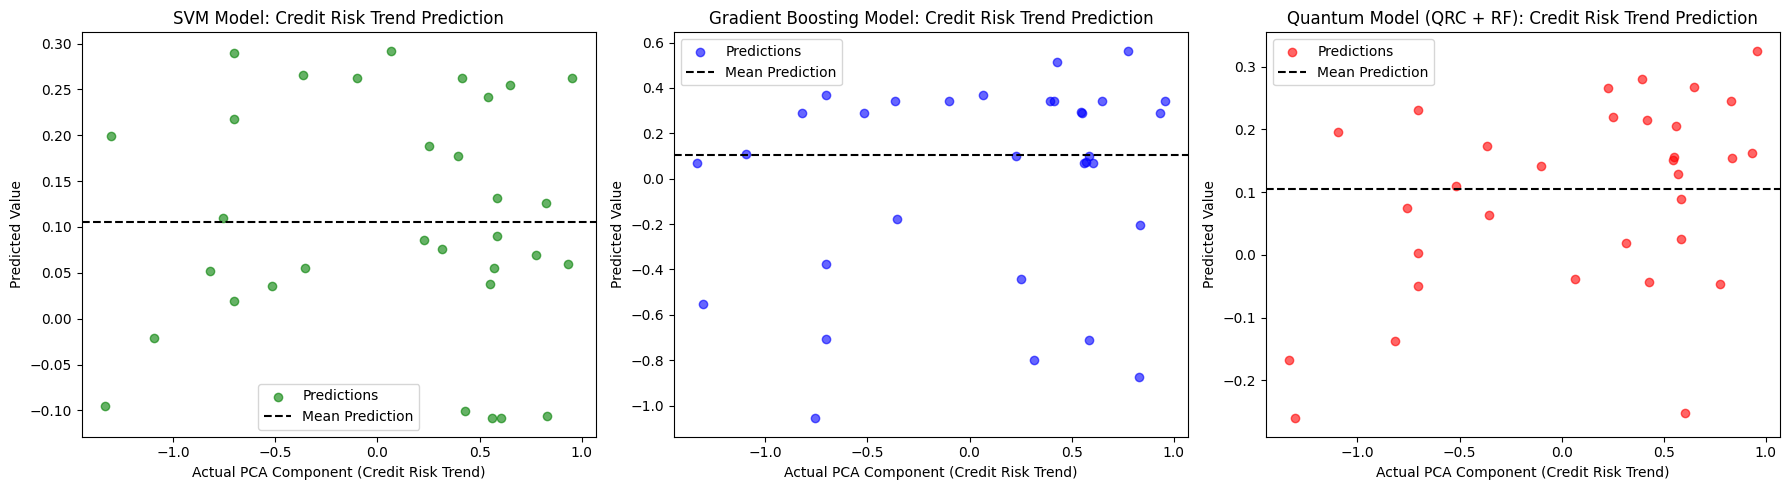

In [18]:

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_seq, y_train_scaled.ravel())

# Train Gradient Boosting Model on Time-Series Features
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_seq, y_train_scaled.ravel())

# Predict with SVM Model
y_pred_svm_scaled = svm_model.predict(X_test_seq)
y_pred_svm_rescaled = y_scaler.inverse_transform(y_pred_svm_scaled.reshape(-1, 1))

# Predict with Gradient Boosting Model
y_pred_gb_scaled = gb_model.predict(X_test_seq)
y_pred_gb_rescaled = y_scaler.inverse_transform(y_pred_gb_scaled.reshape(-1, 1))

# Evaluate SVM Model
mse_svm = mean_squared_error(y_test_seq, y_pred_svm_rescaled)
r2_svm = r2_score(y_test_seq, y_pred_svm_rescaled)

# Evaluate Gradient Boosting Model
mse_gb = mean_squared_error(y_test_seq, y_pred_gb_rescaled)
r2_gb = r2_score(y_test_seq, y_pred_gb_rescaled)

# Evaluate Quantum Model (QRC + RF)
y_pred_quantum_rescaled = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
mse_quantum = mean_squared_error(y_test_seq, y_pred_rescaled)
r2_quantum = r2_score(y_test_seq, y_pred_rescaled)

print("\n🔍 Performance Comparison:")
print(f"SVM Model (Time-Series + SVR) -> MSE: {mse_svm:.4f}, R²: {r2_svm:.4f}")
print(f"Gradient Boosting Model (Time-Series + GB) -> MSE: {mse_gb:.4f}, R²: {r2_gb:.4f}")
print(f"Quantum Model (QRC + RF) -> MSE: {mse_quantum:.4f}, R²: {r2_quantum:.4f}")

# Plot Actual vs. Predicted Values for All Models
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_seq, y_pred_svm_rescaled, color="green", alpha=0.6,label="Predictions")
plt.axhline(y=np.mean(y_pred_svm_rescaled), color="black", linestyle="dashed",label="Mean Prediction")
plt.title("SVM Model: Credit Risk Trend Prediction")
plt.xlabel("Actual PCA Component (Credit Risk Trend)")
plt.ylabel("Predicted Value")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(y_test_seq, y_pred_gb_rescaled, color="blue", alpha=0.6,label="Predictions")
plt.axhline(y=np.mean(y_pred_svm_rescaled), color="black", linestyle="dashed",label="Mean Prediction")
plt.title("Gradient Boosting Model: Credit Risk Trend Prediction")
plt.xlabel("Actual PCA Component (Credit Risk Trend)")
plt.ylabel("Predicted Value")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(y_test_seq, y_pred_rescaled, color="red", alpha=0.6,label="Predictions")
plt.axhline(y=np.mean(y_pred_svm_rescaled), color="black", linestyle="dashed",label="Mean Prediction")
plt.title("Quantum Model (QRC + RF): Credit Risk Trend Prediction")
plt.xlabel("Actual PCA Component (Credit Risk Trend)")
plt.ylabel("Predicted Value")
plt.legend()

plt.tight_layout()
plt.show()
